In [51]:
!python --version

Python 3.12.2


In [ ]:
# Data preprocessing with pandas and numpy
import pandas as pd
import numpy as np
# OS
import os
# Data Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # type: ignore
# Python Image Library
import PIL
# TensorFlow
import tensorflow as tf
# Image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.applications.resnet50 import ResNet50 # type: ignore
from tensorflow.keras.applications import InceptionResNetV2 # type: ignore
from tensorflow.keras.applications.resnet_v2 import ResNet152V2 # type: ignore
from tensorflow.keras.layers import Input # type: ignore
from tensorflow.keras.applications.inception_v3 import InceptionV3 # type: ignore
# Neural Network: layers, models, initializers and utils
from tensorflow.keras.layers import * # type: ignore
from tensorflow.keras.models import Sequential,Model, load_model # type: ignore
from tensorflow.keras.initializers import glorot_uniform # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore
# Showing output
from IPython.display import display # type: ignore
# Backend
from tensorflow.keras import backend as K # type: ignore
# Model Optimizers
from tensorflow.keras.optimizers import SGD, Adam # type: ignore
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler # type: ignore

# Keras
from tensorflow import keras # type: ignore
from random import sample
import random

import warnings
warnings.filterwarnings('ignore')

## 1. Data Preprocessing

**Loading the Data**

- Create variable showing path of the data. For easy navigation.
- Join the path to the specific subdirectory: "training", "validation" or "evaluation"
- Label the data of images under each path with their specific category.(Directory name. eg. Bread)

In [3]:
train = {}
test = {}

# Path to the dataset
path = "C:\\Users\\njugu\\Documents\\Datasets\\Foods"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "training")
# i - the label for each subdirectory containing images
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

# Make dictionary storing images for each category under test data.
path_test = os.path.join(path, "validation")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

In [4]:
len(train)

11

**Checking length of the dataframe**

- We concatenate all the values of of the train values list and get the shape.
- We concatenate all the values of of the test values list and get the shape.
- Print out the lengths of both dataframes.

In [5]:
# View the number of images in the entire training and testing datasets respectively.
len_train = np.concatenate(list(train.values())).shape[0]
len_test = np.concatenate(list(test.values())).shape[0]

print(f"Number of images in training data : {len_train}")
print(f"Number of images in testing data : {len_test}")

Number of images in training data : 9866
Number of images in testing data : 3430


**Visualizing random samples of images**

- Take random images from all the 11 categories and display 5 for each.
- Sample the population values uniquely.
- Label all the images with their category names.
- **NB**: You will see different images every time you run this cell.

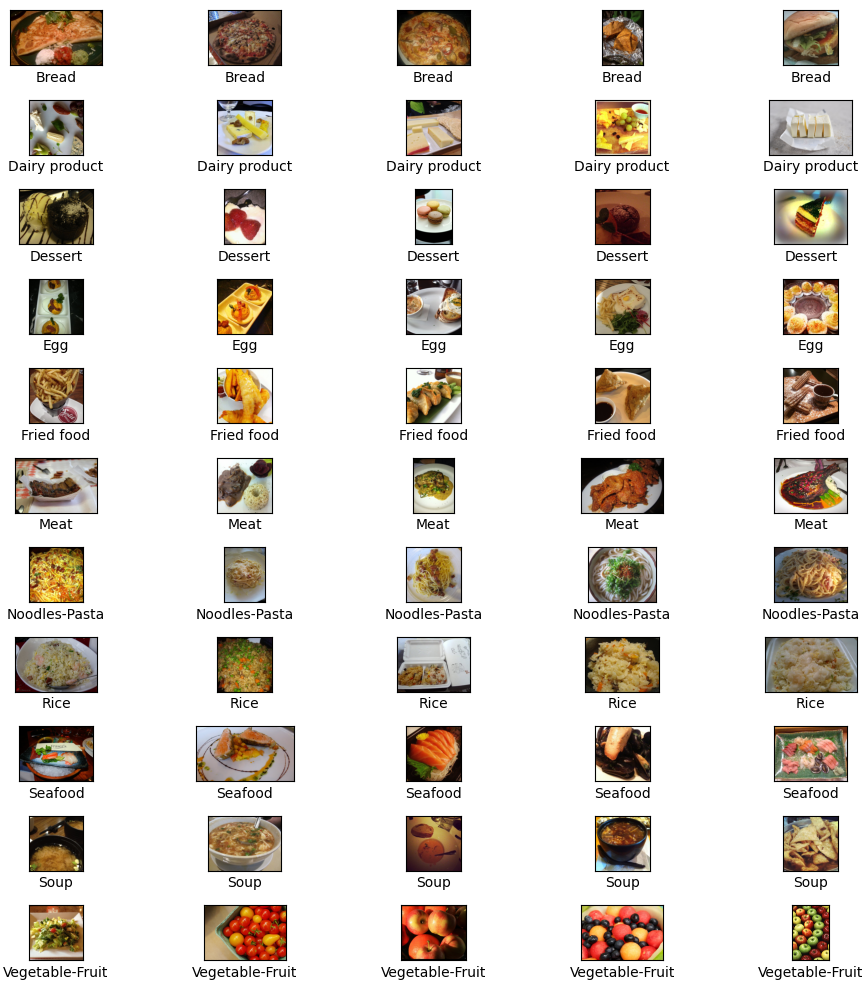

In [6]:
# Randomly display 5 images under each of the 11 categories from the training data.
# You will see different images each time.
fig, axs = plt.subplots(len(train.keys()), 5, figsize = (10, 10))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)
    
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

- **View number of images for each category.**

In [7]:
# View the number of images in each of the 11 categories in the training data.
for item in train.keys():
    print(item, len(train[item]))

Bread 994
Dairy product 429
Dessert 1500
Egg 986
Fried food 848
Meat 1325
Noodles-Pasta 440
Rice 280
Seafood 855
Soup 1500
Vegetable-Fruit 709


- There are 11 food categories in the training dataframe.
- The sizes of each category vary:
  - Bread has 994 images
  - Dairy Product has 429 images
  - Dessert has 1500 images
  - Egg has 986 images
  - Fried food has 848 images
  - Meat has 1325 images
  - Noodles-Pasta has 440 images
  - Rice has 280 images
  - Seafood has 855 images
  - Soup has 1500 images
  - Vegetable-Fruit has 709 images

**Visualizing the distribution of images for each category**

- This is often useful when you want your dataset to be balanced.

**Visualization of Food Classes**

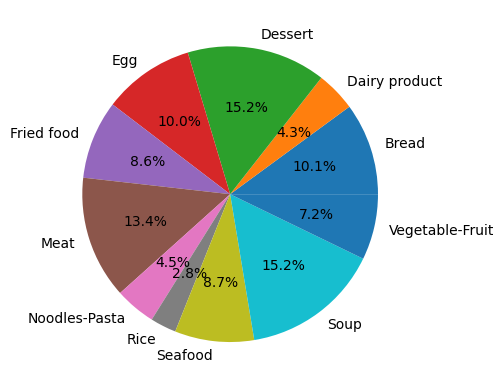

In [8]:
# Make a pie-chart to visualize the percentage contribution of each category.
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

**Image Generator**

- To specify the augmentationto be applied: We will zoom, flip and rescale our images.
- We zoom 0.8 outwards, flip is set to true, and the image is rescaled to (256, 256) dimensions.
- The test data is only rescaled since it may cause inconsistency if we augment the testdata.

In [38]:
# Create an Image Generator and specify the type of data augmentation you want to apply.
# Here we go with zooming, flipping (horizontally and vertically), and rescaling.
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)

# For test data we only rescale the data.
test_datagen = ImageDataGenerator(rescale=1./255)

**Create a pipeline for the images to the model**

- This is to make the images(including augmented ones) to satrt flowing from the directory to the model.
- Create generator for image.
- We choose a batch size of 32, and the images size is made to be (256, 256).

In [37]:
# Create a generator for the images. 
# This will make images (including augmented ones) start flowing from the directory to the model.
# Note that augmented images are not stored along with the original images. The process happens in memory.

# Train generator
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


- **Loading the inception _resnetv2_ model**

**Basemodel**

- Using InceptionResNetV2, we create the base model for our network with the following characteristsics:
  - Pre-trained weights on Imagenet.
  - We exclude the classification head for feature extaction.
  - The input tensor for images is given a shape of (256, 256, 3).

In [41]:
basemodel = InceptionResNetV2(
    weights="imagenet",  # Pre-trained weights on ImageNet
    include_top=False,   # Exclude classification head for feature extraction
    input_tensor=Input(shape=(256, 256, 3)),  # Specify input shape
)

**Basemodel Summary**

- A basemodel is a simple model used to predict the outcome of data.
- This will allow us to assess the performance of the model and the impact of additional features.
- The major importance of getting a summary of the model is to:
  - **Performance comparison:** Helps determine if the complexity of the model translates into improved performance.
  - **Minimum performance requirement**: Set a minimum requirement for a useful model.
  - **Decision-making**: determines resource allocation, model selection and further model improvement.

In [42]:
# print the model summary
basemodel.summary()

Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_406 (Conv2D) │ (None, 127, 127,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d_406[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_406      │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_407 (Conv2D) │ (None, 125, 125,  │      9,216 │ activation_406[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_407[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_407      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_408 (Conv2D) │ (None, 125, 125,  │     18,432 │ activation_407[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_408[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_408      │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 62, 62,    │          0 │ activation_408[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_409 (Conv2D) │ (None, 62, 62,    │      5,120 │ max_pooling2d_14… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_409[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_409      │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_410 (Conv2D) │ (None, 60, 60,    │    138,240 │ activation_409[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_410[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_410      │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

**Freezing basemodel weights**

- This will allow us to see if the model performance increases if the weights are kept constant.
- We set the basemodel trainable feature to False which makes the weights frozen and fail to adjust as the model is trained.

In [43]:
# Freeze the basemodel weights, so these weights won't change during training
basemodel.trainable = False

**Creating a classification head to the model**

- **basemodel**: The base model to which the classification head will be added.

1. Create a pooling for the 2D array.
2. Flatten the 2D array to 1D array.
3. Create hidden layers for learning of the model. In this case, 256 hidden layers and **Rectified Linear Unit**(ReLu)  activation fucntion is selected for this hidden layers dense_1.
4. Drop a 30% of the neurons in each training iteration which will be ignored.
5. Another layer of hidden layers will be introduced having 128 layers, and ReLU activation function for dense_2 layer.
6. We ignore another 30% of neurons in training in this layer.
7. A final layer with 11 output values is created with activation set to _softmax_. 

In [44]:
# Add classification head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = "Global_Average_Pool")(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(256, activation = "relu", name = "dense_1")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = "dense_2")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(11, activation = "softmax", name = "output")(headmodel)


model = Model(inputs = basemodel.input, outputs = headmodel)

**Model Compilation**

- We now compile our model, with our leraning rate set to 0.01.

In [45]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics = ["accuracy"]
)

**Creating of callback values.**

- To prevent early stopping due to poor performance in accuracy, we introduce patience to the model to reduce the chance of the model stopping the process of training due to the accuracy not improving.
- A checkpointer is created to save the best performance points of the model, the check pointer saves the accuracy based on each epoch ran.

In [48]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.keras", 
    verbose = 1, 
    save_best_only = True,
    save_freq = "epoch"
)

**Run a sample epoch to test accuracy of the model**

- With the weights frozen, we run an epoch and observe how the model generally performs.

In [47]:
# Finally, fit the neural network model to the data.
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 1,  
    callbacks = [checkpointer, earlystopping]
)

308/308 ━━━━━━━━━━━━━━━━━━━━ 3129s 10s/step - accuracy: 0.5217 - loss: 1.4734


- We can observe that the accuracy of the model is generally low during this testing, which now requires us to allow the weights to adjust as the model runs.
- The loss remains high.

### HyperParameter Tuning

**Resetting the weights**

- We unfreeze the weights of the model by setting the _basemodel.trainable = True_.

In [49]:
# Unfreeze the weights in the base model, now these weights will be changed during training
basemodel.trainable = True

**Creating of callback values.**

- To prevent early stopping due to poor performance in accuracy, we introduce patience to the model to reduce the chance of the model stopping the process of training due to the accuracy not improving.
- A checkpointer is created to save the best performance points of the model, the check pointer saves the accuracy based on each epoch ran.
- We ensure that only the best performances only will be saved for every running epoch. This will generally allow the model performance to increase on each training iteration.

In [50]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

# Save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights_fine.keras", 
    verbose = 1, 
    save_best_only = True,
    save_freq = "epoch"
)

**Fitting Model**

- The steps are made out of the number of total number of samples in the test generator divided by the batch size, in this case which was 32.
- Using 10 training iterations(epochs) to train the model and obtain the best accuracy.
- We introduce call back functions to contain the model and save the checkpoints. 

In [52]:
# fine tune the model with very low learning rate
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 32, 
    epochs = 10, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 2928s 9s/step - accuracy: 0.7129 - loss: 0.8830
Epoch 2/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7812 - loss: 0.6988 
Epoch 3/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 2819s 9s/step - accuracy: 0.7525 - loss: 0.7754
Epoch 4/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7812 - loss: 0.4701  
Epoch 5/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 2710s 9s/step - accuracy: 0.7601 - loss: 0.7388
Epoch 6/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8438 - loss: 0.5387  
Epoch 7/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 2772s 9s/step - accuracy: 0.7794 - loss: 0.6964
Epoch 8/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8125 - loss: 0.6147  
Epoch 9/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 3212s 10s/step - accuracy: 0.7876 - loss: 0.6582
Epoch 10/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7188 - loss: 0.6949  


**Evaluate accuracy of model**

In [53]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    test_generator, 
    steps = test_generator.n // 32, 
    verbose = 1
)

print(f'Accuracy Test : {evaluate[1]}')

107/107 ━━━━━━━━━━━━━━━━━━━━ 1229s 11s/step - accuracy: 0.8395 - loss: 0.5277
Accuracy Test : 0.8422897458076477


**Re-assigning the label names to the dataset**

In [54]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

## Model Evaluation

**Image Processing**

In [83]:
def preprocess_image(path):
    '''Takes an image path as input

    Args:
        path: image path.
    Return:
        reshaped image object in 4D.
    '''
    # Open and resize image
    try:
        img = PIL.Image.open(path).resize((256, 256))
    except PermissionError:
        print(f"Error accessing image: {path}. Skipping...")
    # Convert to NumPy array and normalize
    if img is not None:
        img = np.asarray(img, dtype=np.float32) / 255
        # Reshape to 4D array
        img = img.reshape(-1, 256, 256, 3)
    return img

**Loading data and predicting the class of the Image**

In [84]:
from os import listdir
from os.path import join

def load_and_predict(path_eval, labels):
    '''Takes the evaluation path and labels list as input.

    Args:
        path_eval: path of data to evaluate.
        labels: the labels of the images.
    Return:
        the lists of predictions and original classes.
    '''
    prediction = []
    original = []
    for folder_name in listdir(path_eval):
        folder_path = join(path_eval, folder_name)
        for image_name in listdir(folder_path):
            image_path = join(folder_path, image_name)
            # Preprocess imag e
            img = preprocess_image(image_path)
            # Make prediction and get class with highest probability
            predict = np.argmax(model.predict(img))
            prediction.append(labels[predict])
            original.append(folder_name)
    return prediction, original

**Logic Execution**

In [ ]:
folder = "C:\\Users\\njugu\\Documents\\Datasets\Foods"
path_eval = os.path.join(folder, "evaluation")
# Call the function with your paths and labels
predictions, originals = load_and_predict(path_eval, labels)

In [101]:
predictions[0]

'Bread'

In [104]:
evaluation = {}
path_evaluate = os.path.join(folder, "evaluation")
for i in os.listdir(path_evaluate):
    evaluation[i] = os.listdir(os.path.join(path_evaluate, i))

In [108]:
# Check out the Classification Report 
print(classification_report(np.asarray(predictions), np.asarray(originals)))

                 precision    recall  f1-score   support

          Bread       0.80      0.83      0.81       353
  Dairy product       0.67      0.74      0.70       134
        Dessert       0.78      0.82      0.80       471
            Egg       0.77      0.80      0.78       321
     Fried food       0.78      0.86      0.82       261
           Meat       0.88      0.83      0.85       453
  Noodles-Pasta       0.98      1.00      0.99       144
           Rice       0.97      0.94      0.95        99
        Seafood       0.91      0.74      0.81       372
           Soup       0.97      0.96      0.97       501
Vegetable-Fruit       0.95      0.92      0.93       238

       accuracy                           0.85      3347
      macro avg       0.86      0.86      0.86      3347
   weighted avg       0.86      0.85      0.85      3347



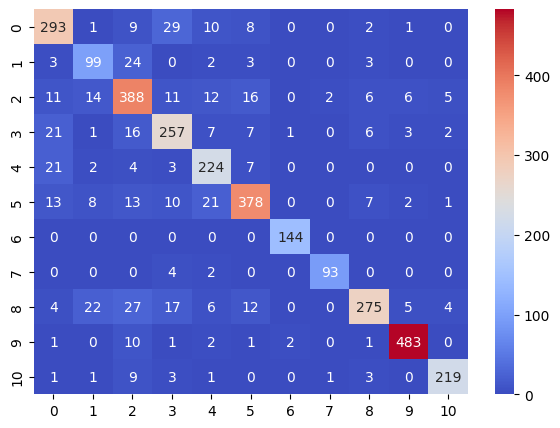

In [112]:
# View the 6x6 confusion matrix
plt.figure(figsize = (7, 5))
cm = confusion_matrix(np.asarray(predictions), np.asarray(originals))
sns.heatmap(
    cm, 
    annot = True, 
    cmap = "coolwarm",
    fmt = "d"
)
plt.show()